In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from scipy.signal import correlate2d, convolve2d

In [19]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)


In [30]:
class ConvLayer:
    def __init__(self, num_filters, filter_size, input_depth):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(filter_size, filter_size, input_depth, num_filters) * 0.1
        self.biases = np.zeros(num_filters)

    def forward(self, input):
        self.last_input = input
        output_height = input.shape[0] - self.filter_size + 1
        output_width = input.shape[1] - self.filter_size + 1
        output = np.zeros((output_height, output_width, self.num_filters))

        for f in range(self.num_filters):
            for c in range(input.shape[-1]):
                output[:, :, f] += correlate2d(input[:, :, c], self.filters[:, :, c, f], mode='valid')
            output[:, :, f] += self.biases[f]
        return output

    def backward(self, grad_output, lr=0.01):
        grad_filters = np.zeros_like(self.filters)
        grad_biases = np.zeros_like(self.biases)
        grad_input = np.zeros_like(self.last_input)

        for f in range(self.num_filters):
            for c in range(self.last_input.shape[-1]):
                grad_filters[:, :, c, f] = convolve2d(self.last_input[:, :, c], grad_output[:, :, f], mode='valid')
                grad_input[:, :, c] += convolve2d(grad_output[:, :, f], self.filters[:, :, c, f], mode='full')
            grad_biases[f] = np.sum(grad_output[:, :, f])

        self.filters -= lr * grad_filters
        self.biases -= lr * grad_biases
        return grad_input

In [31]:
class MaxPool2x2:
    def forward(self, input):
        self.last_input = input
        h, w, d = input.shape
        output = np.zeros((h//2, w//2, d))
        self.switch = np.zeros_like(input)

        for i in range(h//2):
            for j in range(w//2):
                for k in range(d):
                    patch = input[i*2:(i+1)*2, j*2:(j+1)*2, k]
                    output[i, j, k] = np.max(patch)
                    self.switch[i*2:(i+1)*2, j*2:(j+1)*2, k] = (patch == np.max(patch))
        return output

    def backward(self, grad_output):
        grad_input = np.zeros_like(self.last_input)
        for i in range(grad_output.shape[0]):
            for j in range(grad_output.shape[1]):
                for k in range(grad_output.shape[2]):
                    grad_input[i*2:(i+1)*2, j*2:(j+1)*2, k] = grad_output[i, j, k] * self.switch[i*2:(i+1)*2, j*2:(j+1)*2, k]
        return grad_input


In [32]:
class ReLU:
    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backward(self, grad_output):
        return grad_output * (self.last_input > 0)


In [33]:
class Flatten:
    def forward(self, input):
        self.orig_shape = input.shape
        return input.flatten()

    def backward(self, grad_output):
        return grad_output.reshape(self.orig_shape)

In [34]:
class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros(output_size)

    def forward(self, input):
        self.last_input = input
        return np.dot(input, self.weights) + self.biases

    def backward(self, grad_output, lr=0.01):
        grad_weights = np.outer(self.last_input, grad_output)
        grad_biases = grad_output
        grad_input = np.dot(grad_output, self.weights.T)

        self.weights -= lr * grad_weights
        self.biases -= lr * grad_biases
        return grad_input


In [36]:
class CNN:
    def __init__(self, input_shape=(16, 16, 1)):
        self.layers = [
            ConvLayer(4, 3, input_shape[-1]),
            ReLU(),
            MaxPool2x2(),
            ConvLayer(8, 3, 4),
            ReLU(),
            ConvLayer(16, 3, 8),
            ReLU(),
            Flatten(),
            DenseLayer(144, 10)
        ]

    def forward(self, x):
        layer_outputs = []
        for layer in self.layers:
            x = layer.forward(x)
            layer_outputs.append(x)
        return layer_outputs

    def visualize_layers(self):
        layer_outputs = self.forward(x_test_resized[0])

        layer_names = ["Conv1", "ReLU1", "MaxPool", "Conv2", "ReLU2", "Conv3", "ReLU3", "Flatten", "Dense"]
        for i, layer_output in enumerate(layer_outputs):
            plt.figure(figsize=(12, 12))
            if len(layer_output.shape) == 3:
                num_filters = layer_output.shape[-1]
                for f in range(num_filters):
                    plt.subplot(1, num_filters, f+1)
                    plt.imshow(layer_output[:, :, f], cmap='gray')
                    plt.title(f"{layer_names[i]} - Filter {f+1}")
                    plt.axis('off')
                plt.show()
            elif len(layer_output.shape) == 1:
                plt.subplot(1, 1, 1)
                plt.plot(layer_output)
                plt.title(f"{layer_names[i]} - Flattened Output")
                plt.show()

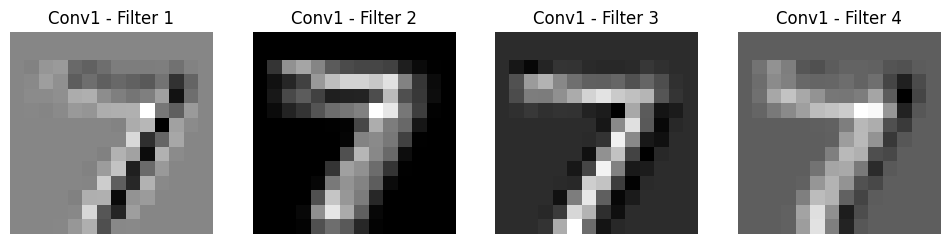

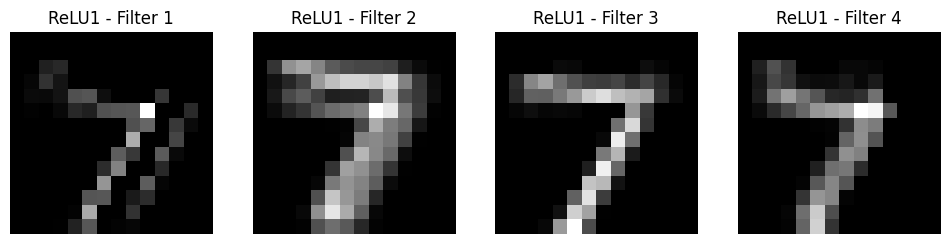

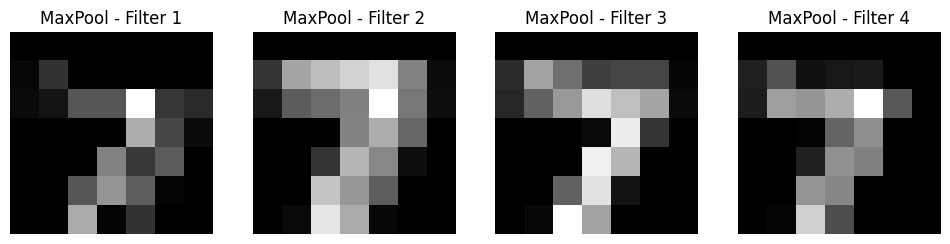

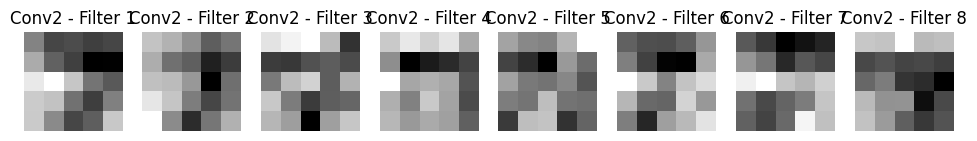

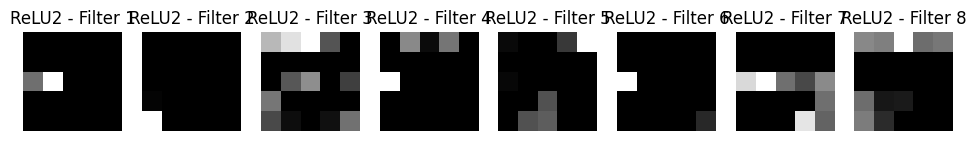

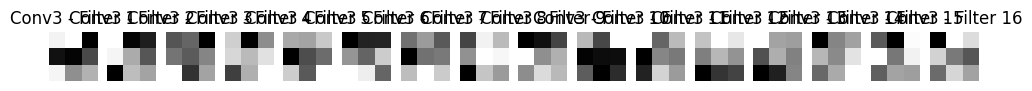

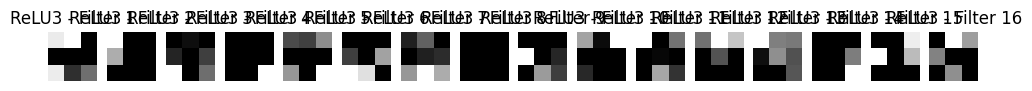

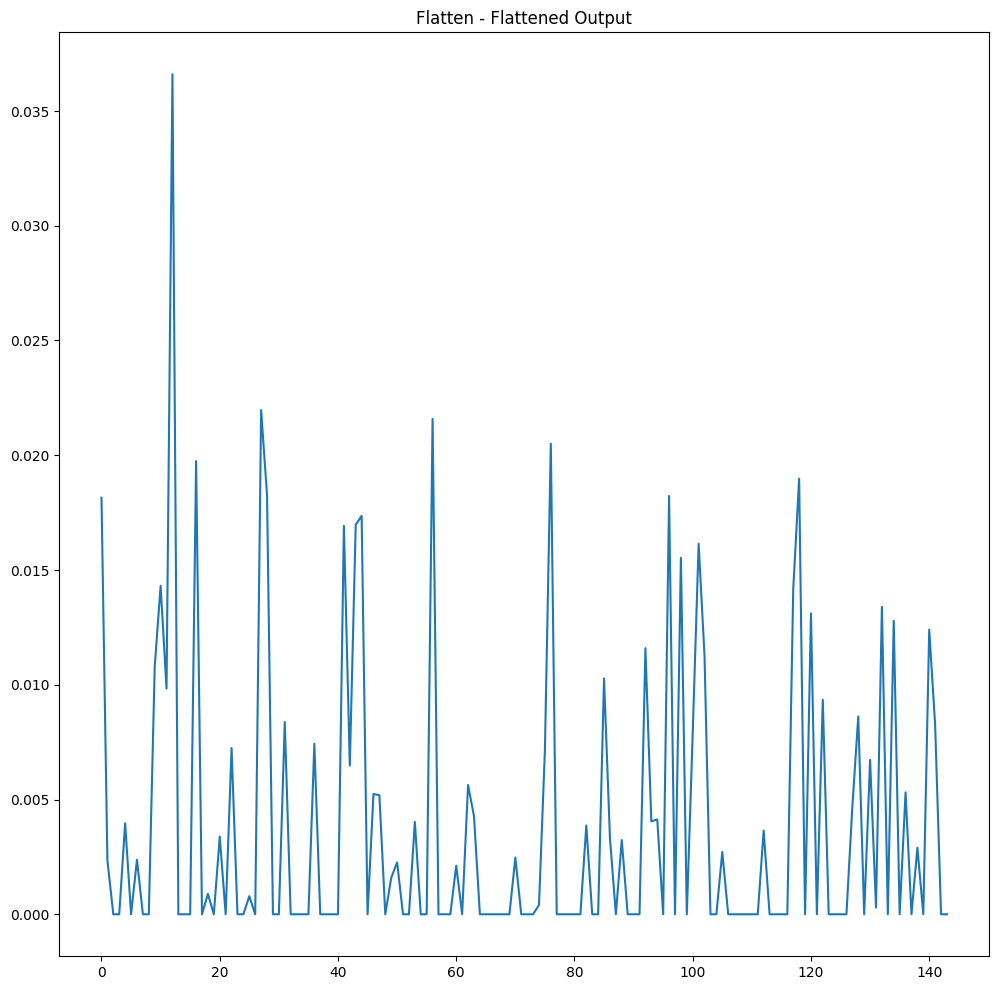

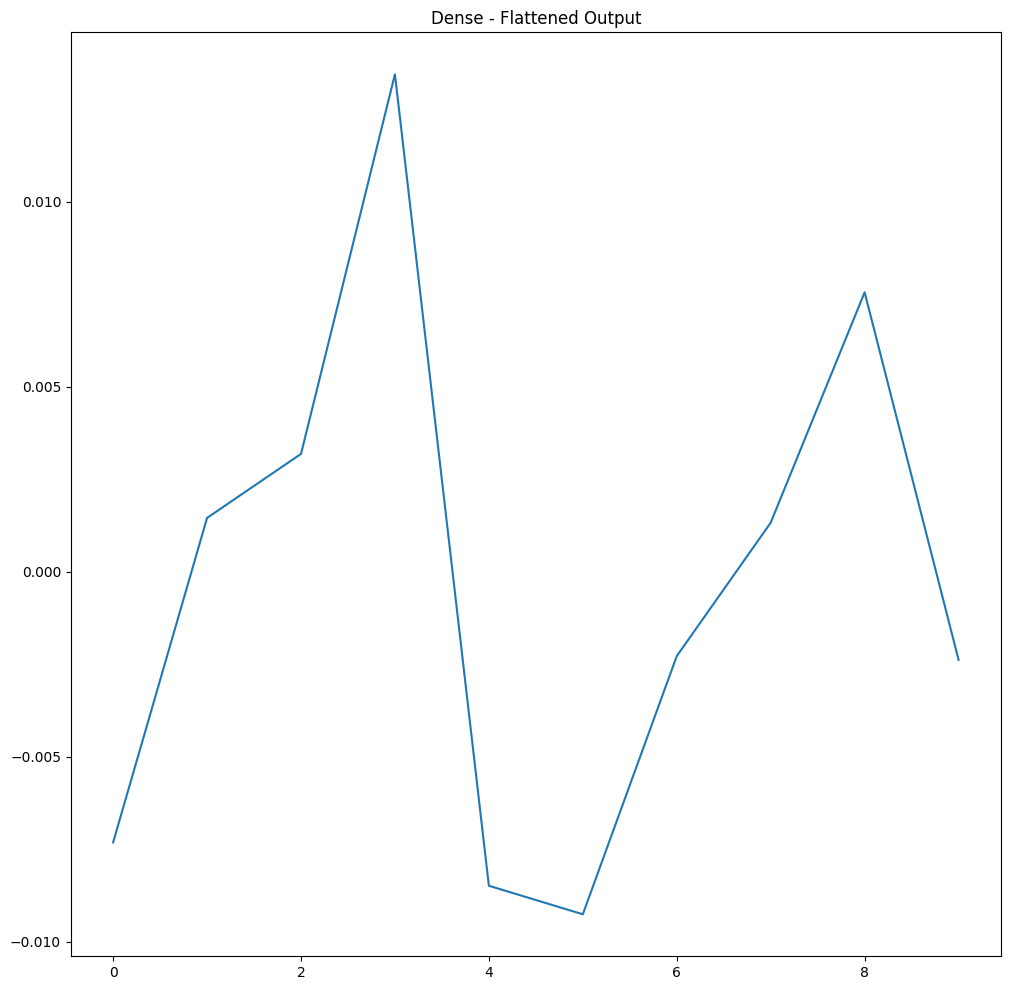

In [37]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train_resized = np.array([cv2.resize(img, (16, 16)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (16, 16)) for img in x_test])

x_train_resized = x_train_resized[..., np.newaxis]
x_test_resized = x_test_resized[..., np.newaxis]

cnn = CNN(input_shape=(16, 16, 1))

cnn.visualize_layers()